## Prepare

In [1]:
!pip install -q transformers

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) 
Token is valid.
Cannot authenticate through git-credential as no helpe

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install

In [4]:
!pip install -q datasets
!pip install -q lang_trans
!pip install -q arabic_reshaper
!pip install -q python-bidi
!pip install -q pydub
!pip install -q soundfile
!pip install -q jiwer
!pip install -q PyArabic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 KB 3.6 MB/s eta 0:00:00


# Imports

In [5]:
import transformers
transformers.utils.move_cache()

Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [6]:
import tensorflow as tf

In [9]:
import os
import re
import sys
import json
import torch
import jiwer
import logging
import librosa
import datasets
import itertools
import torchaudio
import numpy as np
import transformers
import pandas as pd
from torch import nn
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
import soundfile as sf
import arabic_reshaper
from jiwer import wer,cer
from pyarabic import araby
from packaging import version
from pydub import AudioSegment
from dataclasses import asdict
import matplotlib.pyplot as plt
from pydub.utils import mediainfo
from argparse import ArgumentParser
from collections import defaultdict
from torch.nn import functional as F
from contextlib import contextmanager
from bidi.algorithm import get_display
from lang_trans.arabic import buckwalter
from dataclasses import dataclass, field
from sklearn.metrics import accuracy_score
from typing import Any, Dict, List, Optional, Union
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset,load_metric
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import HfArgumentParser,TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix
from transformers.trainer_utils import get_last_checkpoint, is_main_process
from transformers import is_apex_available,set_seed ,Trainer,Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2Model,Wav2Vec2PreTrainedModel
%matplotlib inline

# Prepare the private dataset

In [10]:
!cp -r /content/drive/MyDrive/KFUPM-Master/ICS606/Dataset/dataset_wav.zip .

In [11]:
if os.path.exists('dataset_wav'):
  if len(os.listdir('dataset_wav')) == 0:
    os.system('unzip dataset_wav.zip')
else:
  os.system('unzip dataset_wav.zip')

In [12]:
metadata_path = '/content/drive/MyDrive/KFUPM-Master/ICS606/Dataset/metadata.xlsx'
test_metadata_path = '/content/drive/MyDrive/KFUPM-Master/ICS606/Dataset/test_metadata.xlsx'

In [13]:
!cp $metadata_path .
!cp $test_metadata_path .

In [14]:
dataset_wav_folder = 'dataset_wav'

In [15]:
def preprocess_metadata(metadata):
  metadata['Bahr'] = metadata['Bahr'].apply(lambda bahr: bahr.strip() if isinstance(bahr,str) else bahr)
  metadata['Clean Script'] = metadata['Script'].apply(lambda script: araby.strip_tashkeel(araby.strip_tatweel(script)))
  metadata['File Exist'] = metadata['Utterance name'].apply(lambda file_name: os.path.isfile(f'{dataset_wav_folder}/{file_name}'))
  metadata = metadata[metadata['File Exist'] == True]
  return metadata

In [16]:
metadata = preprocess_metadata(pd.read_excel(metadata_path))
test_metadata = preprocess_metadata(pd.read_excel(test_metadata_path))
train_metadata = metadata[[script not in test_metadata['No.'].values for script in metadata['No.']]]
train_metadata

,No.,Utterance name,Script,Bahr,Source,Name when extacted,Original name in document,Is_Malformed,Reciter_Label,Reciter_Gender,Further info on Bahr,Name of document,Clean Script,File Exist
0,1.0,P-1.aac,شتَّ شَعبُ الحيِّ بعدَ التئامْ وشجاكَ الر...,المديد,ديوان الطرماح ص227,1.aac,1.aac,0.0,0.0,0.0,NaN,بحر المديد,شت شعب الحي بعد التئام وشجاك الربع ربع ال...,True
1,2.0,P-2.aac,حَسَرَتْ عَنْهُ الرِّيَاحُ فَأَبْدَتْ من...,المديد,ديوان الطرماح ص227,2.aac,2.aac,0.0,0.0,0.0,NaN,NaN,حسرت عنه الرياح فأبدت منتأى كالقرو رهن ا...,True
2,3.0,P-3.aac,وخصيفَ اللَّونِ جادَتْ بهِ مَرْخَةٌ مِنْ ...,المديد,ديوان الطرماح ص227,3.aac,3.aac,0.0,0.0,0.0,NaN,NaN,وخصيف اللون جادت به مرخة من مخدج أو تمام,True
3,4.0,P-4.aac,بَيْنَ أظْآرٍ بِمَظْلُومَةٍ كَسَرَاةِ الس...,المديد,ديوان الطرماح ص227,4.aac,4.aac,0.0,0.0,0.0,NaN,NaN,بين أظآر بمظلومة كسراة الساق ساق الحمام,True
4,5.0,P-5.aac,مَنْزِلًا كَانَ لَنَا مَرَّةً وطنًا نحتلّ...,المديد,ديوان الطرماح ص227,5.aac,5.aac,0.0,0.0,0.0,NaN,NaN,منزلا كان لنا مرة وطنا نحتله كل عام,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3681,3731.0,P-3731.mp3,وَلِّ السَلاطينَ مَن تَوَلّاها وَاِلجَأ إ...,المنسرح,-,45.mp3,45.mp3,NaN,NaN,NaN,NaN,NaN,ول السلاطين من تولاها والجأ إليه تكن حدياها,True
3682,3732.0,P-3732.mp3,وَلا تَغُرَّنَّكَ الإِمارَةُ في غَيرِ أَم...,المنسرح,-,46.mp3,46.mp3,NaN,NaN,NaN,NaN,NaN,ولا تغرنك الإمارة في غير أمير وإن بها باهى,True
3683,3733.0,P-3733.mp3,فَإِنَّما المَلكُ رَبُّ مَملَكَةٍ قَد فَغ...,المنسرح,-,47.mp3,47.mp3,NaN,NaN,NaN,NaN,NaN,فإنما الملك رب مملكة قد فغم الخافقين سرياها,True
3684,3734.0,P-3734.mp3,مُبتَسِمٌ وَالوُجوهُ عابِسَةٌ سِلمُ العِد...,المنسرح,-,48.mp3,48.mp3,NaN,NaN,NaN,NaN,NaN,مبتسم والوجوه عابسة سلم العدى عنده كهيجاها,True


In [17]:
test_metadata

,No.,Utterance name,Script,Bahr,Source,Name when extacted,Original name in document,Further info on Bahr,Name of document,Clean Script,File Exist
0,89.0,P-89.aac,إنَّ بالشِّعبِ الَّذي دُونَ سَلْعٍ لَقتيل...,المديد,ديوان ثابت بن جابرص35,89.aac,89.aac,NaN,NaN,إن بالشعب الذي دون سلع لقتيلا دمه ما يطل,True
1,90.0,P-90.aac,خَلَّفَ الْعِبْءَ عَلَيَّ وَولَّى أنا بال...,المديد,ديوان ثابت بن جابرص35,90.aac,90.aac,NaN,NaN,خلف العبء علي وولى أنا بالعبء له مستقل,True
2,91.0,P-91.aac,ووراءَ الثَّأر منِّي ابنُ أختٍ مَصِعٌ عُق...,المديد,ديوان ثابت بن جابرص35,91.aac,91.aac,NaN,NaN,ووراء الثأر مني ابن أخت مصع عقدته ما تحل,True
3,92.0,P-92.aac,مُطْرِقٌ يَرْشَحُ سَمًّا كَمَا أَطْ رَقَ ...,المديد,ديوان ثابت بن جابرص35,92.aac,92.aac,NaN,NaN,مطرق يرشح سما كما أط رق أفعى ينفث السم صل,True
4,93.0,P-93.aac,خبرٌ ما نابَنا مُصْمَئِلٌّ جلَّ حتّى دقَّ...,المديد,ديوان ثابت بن جابرص35,93.aac,93.aac,NaN,NaN,خبر ما نابنا مصمئل جل حتى دق فيه الأجل,True
...,...,...,...,...,...,...,...,...,...,...,...
354,3682.0,P-3682.m4a,حِسانُ الوُجوهِ حِدادُ السُيو فِ يَبتَدِر...,المتقارب,ديوان قيس بن الخطيم ص 73,ÇáÊÓÌíá (98).m4a,التسجيل (98).m4a,NaN,NaN,حسان الوجوه حداد السيو ف يبتدر المجد شبانها,True
355,3683.0,P-3683.m4a,وَبِالشَوطِ مِن يَثرِبٍ أَعبُدٌ سَتَهلِكُ...,المتقارب,ديوان قيس بن الخطيم ص 73,ÇáÊÓÌíá (99).m4a,التسجيل (99).m4a,NaN,NaN,وبالشوط من يثرب أعبد ستهلك في الخمر أثمانها,True
356,3684.0,P-3684.m4a,يَهونُ عَلى الأَوسِ أَثمانُهُم إِذا راحَ ...,المتقارب,ديوان قيس بن الخطيم ص 73,ÇáÊÓÌíá (100).m4a,التسجيل (100).m4a,NaN,NaN,يهون على الأوس أثمانهم إذا راح يخطر نشوانها,True
357,3685.0,P-3685.m4a,أَتَتهُم عَرانينُ مِن مالِكٍ سِراعٌ إِلى ...,المتقارب,ديوان قيس بن الخطيم ص 73,ÇáÊÓÌíá (101).m4a,التسجيل (101).m4a,NaN,NaN,أتتهم عرانين من مالك سراع إلى الروع فتيانها,True


# Create wrapper classes

In [18]:
class GheithTextClassifier:
  char2idx = {
    ' ': 0,
    'ء': 1,
    'آ': 2,
    'أ': 3,
    'ؤ': 4,
    'إ': 5,
    'ئ': 6,
    'ا': 7,
    'ب': 8,
    'ة': 9,
    'ت': 10,
    'ث': 11,
    'ج': 12,
    'ح': 13,
    'خ': 14,
    'د': 15,
    'ذ': 16,
    'ر': 17,
    'ز': 18,
    'س': 19,
    'ش': 20,
    'ص': 21,
    'ض': 22,
    'ط': 23,
    'ظ': 24,
    'ع': 25,
    'غ': 26,
    'ف': 27,
    'ق': 28,
    'ك': 29,
    'ل': 30,
    'م': 31,
    'ن': 32,
    'ه': 33,
    'و': 34,
    'ى': 35,
    'ي': 36,
    'ً': 37,
    'ٌ': 38,
    'ٍ': 39,
    'َ': 40,
    'ُ': 41,
    'ِ': 42,
    'ّ': 43,
    'ْ': 44
  }

  meter_class_to_label = {
    0: 'البسيط',
    1: 'الخفيف',
    2: 'الرجز',
    3: 'الرمل',
    4: 'السريع',
    5: 'الطويل',
    6: 'الكامل',
    7: 'المتدارك',
    8: 'المتقارب',
    9: 'المجتث',
    10: 'المديد',
    11: 'المضارع',
    12: 'المقتضب',
    13: 'المنسرح',
    14: 'الهزج',
    15: 'الوافر',
    16: 'نثر'
  }

  meter_label_to_class = {
    "البسيط": 0,
    "الخفيف": 1,
    "الرجز": 2,
    "الرمل": 3,
    "السريع": 4,
    "الطويل": 5,
    "الكامل": 6,
    "المتدارك": 7,
    "المتقارب": 8,
    "المجتث": 9,
    "المديد": 10,
    "المضارع": 11,
    "المقتضب": 12,
    "المنسرح": 13,
    "الهزج": 14,
    "الوافر": 15,
    "نثر": 16,
}
  def __init__(self):
        self.model = tf.keras.models.load_model('/content/drive/MyDrive/KFUPM-Master/ICS606/Models/arabic_poetry_text_classification_model_Gheith.h5')

  def classify(self, bait_text):
      bait_text = araby.strip_tashkeel(bait_text)
      sequence = [self.char2idx[char]+1 for char in bait_text if char in self.char2idx.keys()]
      sequence = pad_sequences([sequence], maxlen=128, padding="post", value=0)
      predictions = self.model.predict(sequence)[0]
      class_ = np.argmax(predictions, 0).astype("int")
      return self.meter_class_to_label[class_]

# Create Objects

In [19]:
classifier = GheithTextClassifier()

# Evaluate

## Prepare and Create the datasets objects

In [20]:
# This dict is used for the benchmark dataset where the meter names are in English
bahr_en_ar_map = {'baseet':'البسيط',
 'hazaj':'الهزج',
 'kamel':'الكامل',
 'khafeef':'الخفيف',
 'madeed':'المديد',
 'mudhare':'المضارع',
 'mujtath':'المجتث',
 'munsareh':'المنسرح',
 'muqtatheb':'المقتضب',
 'mutadarak':'المتدارك',
 'mutakareb':'المتقارب',
 'rajaz':'الرجز',
 'ramal':'الرمل',
 'saree':'السريع',
 'taweel':'الطويل',
 'wafer':'الوافر',
 }

In [21]:
meter_class_to_label = {v:k for k,v in {
    0: 'البسيط',
    1: 'الخفيف',
    2: 'الرجز',
    3: 'الرمل',
    4: 'السريع',
    5: 'الطويل',
    6: 'الكامل',
    7: 'المتدارك',
    8: 'المتقارب',
    9: 'المجتث',
    10: 'المديد',
    11: 'المضارع',
    12: 'المقتضب',
    13: 'المنسرح',
    14: 'الهزج',
    15: 'الوافر',
    16: 'نثر'
}.items()}

In [22]:
meter_class_to_label.keys()

dict_keys(['البسيط', 'الخفيف', 'الرجز', 'الرمل', 'السريع', 'الطويل', 'الكامل', 'المتدارك', 'المتقارب', 'المجتث', 'المديد', 'المضارع', 'المقتضب', 'المنسرح', 'الهزج', 'الوافر', 'نثر'])

In [23]:
def compute_metrics(preds,labels):
    named_preds = [meter_class_to_label[item] for item in preds]
    named_labels = [meter_class_to_label[item] for item  in labels]
    print('labels:',named_labels)
    print('predictions:',named_preds)
    acc = accuracy_score(named_labels, named_preds)
    report = classification_report(named_labels, named_preds)
    matrix = confusion_matrix(named_labels, named_preds)
    print(matrix)
    print('clasification report',report)
    print('accuracy',acc)
    return matrix

In [24]:
private_test_dataset = Dataset.from_pandas(test_metadata)

In [25]:
benchmark_test_dataset = load_dataset("MagedSaeed/arabic_poetry_speech_benchmark", use_auth_token=True)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/268 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/MagedSaeed___parquet/MagedSaeed--arabic_poetry_speech_benchmark-ddc1f2d240ee27b8/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
def clean(example):
  bait = example['bait']
  example['clean bait'] = re.sub('\s+',' ',araby.strip_tashkeel(araby.strip_tatweel(bait)).replace('#',' ').replace('(','').replace(')',''))
  return example

In [27]:
benchmark_test_dataset = benchmark_test_dataset.map(clean)

  0%|          | 0/268 [00:00<?, ?ex/s]

In [28]:
private_test_dataset = private_test_dataset.map(
    lambda example: {
        **example,
        'Clean Script':re.sub('\s+',' ',example['Clean Script']).strip()
      }
    )

  0%|          | 0/359 [00:00<?, ?ex/s]

In [32]:
for item in private_test_dataset['Clean Script']:
  print(item)

إن بالشعب الذي دون سلع لقتيلا دمه ما يطل
خلف العبء علي وولى أنا بالعبء له مستقل
ووراء الثأر مني ابن أخت مصع عقدته ما تحل
مطرق يرشح سما كما أط رق أفعى ينفث السم صل
خبر ما نابنا مصمئل جل حتى دق فيه الأجل
بزني الدهر وكان غشوما بأبي جاره ما يذل
شامس في القر حتى إذا ما ذكت الشعرى فبرد وظل
يابس الجنبين من غير بؤس وندي الكفين شهم مدل
ظاعن بالحزم حتى إذا ما حل حل الحزم حيث يحل
غيث مزن غامر حيث يجدي وإذا يسطو فليث أبل
مسبل في الحي أحوى رفل وإذا يعدو فسمع أزل
وله طعمان أري وشري وكلا الطعمين قد ذاق كل
يركب الهول وحيدا ولا يص حبه إلا اليماني الأفل
وفتو هجروا ثم أسروا ليلهم حتى إذا انجاب حلوا
كل ماض قد تردى بماض كسنا البرق إذا ما يسل
فاحتسوا أنفاس نوم فلما ثملوا رعتهم فاشمعلوا
فادركنا الثأر منهم ولما ينج ملحيين إلا الأقل
فلئن فلت هذيل شباه لبما كان هذيلا يفل
وبما أبركهم في مناخ جعجع ينقب فيه الأظل
وبما صبحها في ذراها منه بعد القتل نهب وشل
صليت مني هذيل بخرق لا يمل الشر حتى يملوا
ينهل الصعدة حتى إذا ما نهلت كان لها منه عل
تضحك الضبع لقتلى هذيل وترى الذئب لها يستهل
وعتاق الطير تغدو بطانا تتخطاهم فما 

In [34]:
for item in benchmark_test_dataset['train']['clean bait']:
  print(item)

لقد أتعبني الدهر بقصد شر ما قصد
أنيق الحسن مياس مليح الخد والقد
لقد هاج لي الوجد غزال دائم الصد
إلى من أشتكي ما بي من الإفلاس والجهد
فداخلت ذوي الأعما ل في هزل وفي جد
وما بي سلوة عنه ولكن قل ما عندي
فلم أربح من الحرص سوى الغربة والكد
له وجه هلالي إذا ما لاح في المرد
ففي مقلته سحر وفي الريقة كالشهد
يقولون سلا عنه وقد حال عن العهد
فإن لم يدنوا حتى ترى رأسيهما راسا
فصور هاهنا فوزا وصور ثم عباسا
إذا ما شئت أن تصن ع شيئا يعجب الناسا
وقس بينهما شبرا فإن زدت فلا باسا
فكذبها بما قاست وكذبه بما قاسى
وتدري كيف معشوق تحسى في الهوى كاسا
ويد تمتد نحوي، كيد من خلال الموج مدت لغريق
كيف ذاك الحب أمسى خبرا وحديثا من أحاديث الجوى
ما احتفاظي بعهود لم تصنها وإلام الأسر والدنيا لدى
لست أناك وقد أغريتني بفم عذب المناداة رقيق
لك إبطاء المدل المنعم وتجني القادر المحتكم
أين من عيني حبيب ساحر فيه عز وجلال وحياء؟
أعطني حريتي أطلق يديا إنني أعطيت ما استبقيت شيئا
يا رسول الله هذا حمزة أترى عيناك منه المصرعا
طلبوه وتنادى جمعهم نكبة حلت وخطب وقعا
غاب عن أعينهم في غمرة سد غول الهول منها المطلعا
إنه عمك إلا أذنا قطعت 

## Meter Classification

### Private Dataset

In [35]:
def predict(example):
  example['predicted'] = classifier.classify(bait_text=example['Clean Script'])
  # example['ctc_predicted'] = classifier_with_ctc_transcibier.classify(speech_array=example["speech_array"])
  # example['bahr_ar'] = bahr_en_ar_map[example['bahr']]
  return example

In [36]:
private_test_dataset = private_test_dataset.map(predict)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_2
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
......

  0%|          | 0/359 [00:00<?, ?ex/s]

1/1 [==============================] - 0s 316ms/step


In [37]:
matrix = compute_metrics(
    preds=[example['predicted'] for example in private_test_dataset],
    labels=[example['Bahr'] for example in private_test_dataset]
  )

labels: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 15, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 1, 1, 1, 1

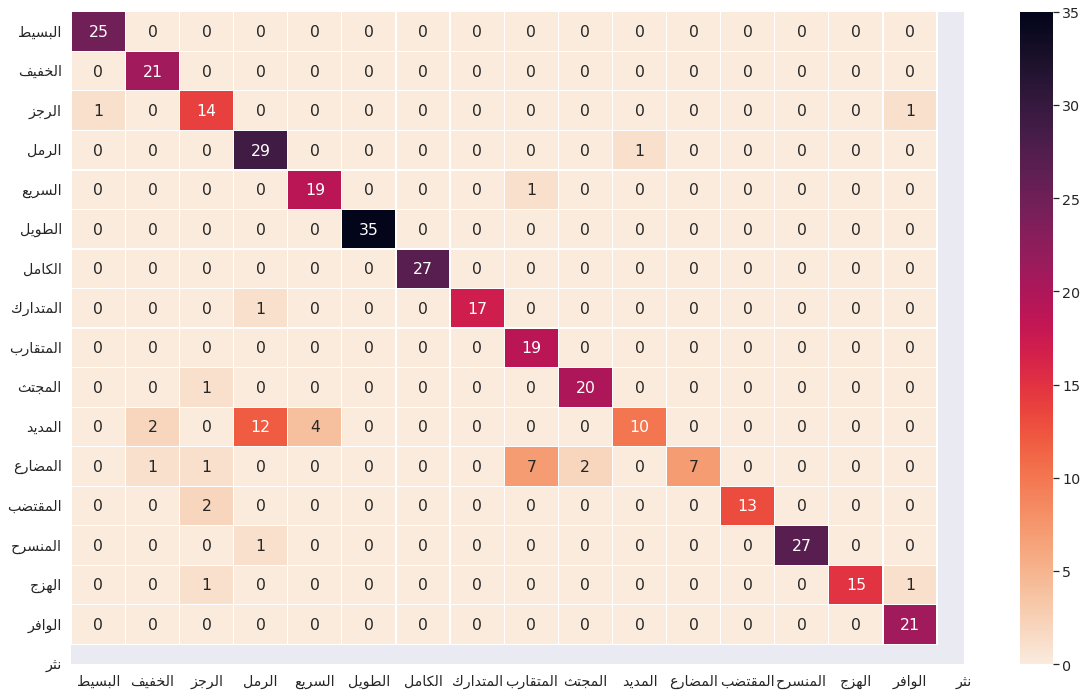

In [38]:
plt.figure(figsize = (20,12))
sns.set(font_scale=1.3)
# sns.heatmap(matrix, annot=True,linewidths=2)
sns.heatmap(
    matrix,
    annot=True,
    linewidths=.2, 
    cmap="rocket_r",
    xticklabels=[get_display(arabic_reshaper.reshape(key)) for key in meter_class_to_label.keys()], 
    yticklabels=[get_display(arabic_reshaper.reshape(key)) for key in meter_class_to_label.keys()],
  )

In [50]:
madeeds = [item['Clean Script'] for item in private_test_dataset if item['Bahr'] == 'المديد']
print(madeeds)

['إن بالشعب الذي دون سلع لقتيلا دمه ما يطل', 'خلف العبء علي وولى أنا بالعبء له مستقل', 'ووراء الثأر مني ابن أخت مصع عقدته ما تحل', 'مطرق يرشح سما كما أط رق أفعى ينفث السم صل', 'خبر ما نابنا مصمئل جل حتى دق فيه الأجل', 'بزني الدهر وكان غشوما بأبي جاره ما يذل', 'شامس في القر حتى إذا ما ذكت الشعرى فبرد وظل', 'يابس الجنبين من غير بؤس وندي الكفين شهم مدل', 'ظاعن بالحزم حتى إذا ما حل حل الحزم حيث يحل', 'غيث مزن غامر حيث يجدي وإذا يسطو فليث أبل', 'مسبل في الحي أحوى رفل وإذا يعدو فسمع أزل', 'وله طعمان أري وشري وكلا الطعمين قد ذاق كل', 'يركب الهول وحيدا ولا يص حبه إلا اليماني الأفل', 'وفتو هجروا ثم أسروا ليلهم حتى إذا انجاب حلوا', 'كل ماض قد تردى بماض كسنا البرق إذا ما يسل', 'فاحتسوا أنفاس نوم فلما ثملوا رعتهم فاشمعلوا', 'فادركنا الثأر منهم ولما ينج ملحيين إلا الأقل', 'فلئن فلت هذيل شباه لبما كان هذيلا يفل', 'وبما أبركهم في مناخ جعجع ينقب فيه الأظل', 'وبما صبحها في ذراها منه بعد القتل نهب وشل', 'صليت مني هذيل بخرق لا يمل الشر حتى يملوا', 'ينهل الصعدة حتى إذا ما نهلت كان لها منه عل', 'تضحك الضبع

### Benchmark Dataset

In [39]:
def predict(example):
  example['predicted'] = classifier.classify(bait_text=example['clean bait'])
  example['bahr_ar'] = bahr_en_ar_map[example['bahr']]
  return example

In [40]:
benchmark_test_dataset = benchmark_test_dataset.map(predict)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_2
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
......

  0%|          | 0/268 [00:00<?, ?ex/s]

1/1 [==============================] - 0s 324ms/step


In [41]:
matrix = compute_metrics(
    preds=[example['predicted'] for example in benchmark_test_dataset['train']],
    labels=[example['bahr_ar'] for example in benchmark_test_dataset['train']]
  )

labels: [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
predictions: [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 16, 14, 3, 3, 3, 3, 3, 3, 3,

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


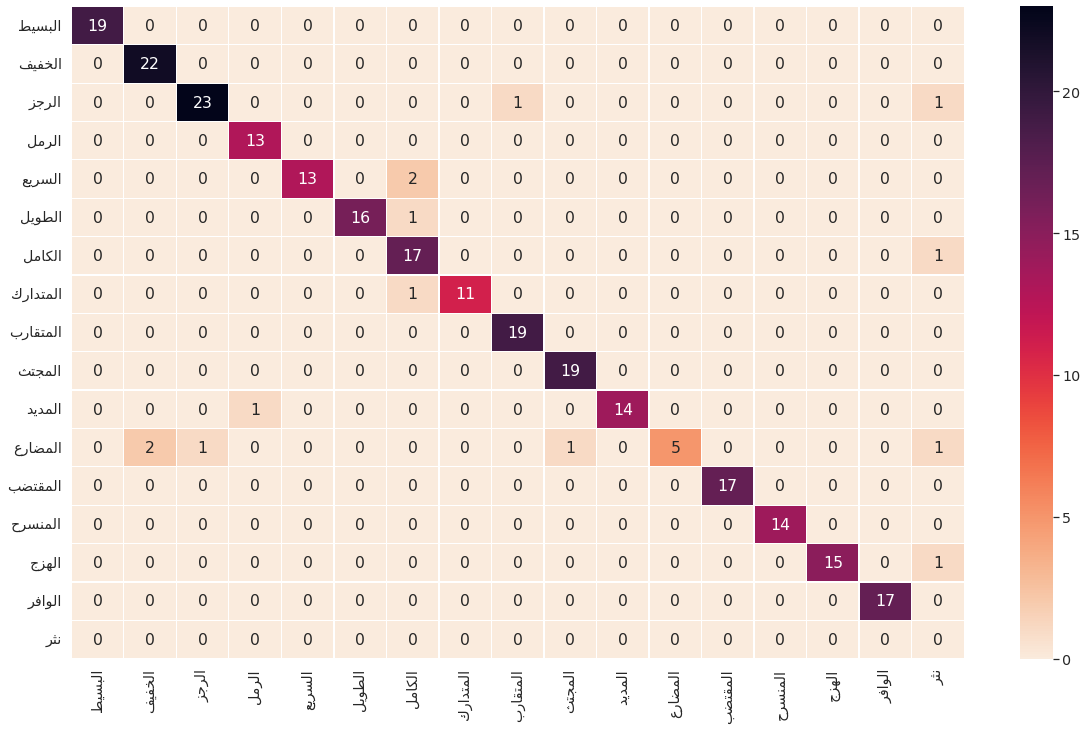

In [42]:
plt.figure(figsize = (20,12))
sns.set(font_scale=1.3)
# sns.heatmap(matrix, annot=True,linewidths=2)
sns.heatmap(
    matrix,
    annot=True,
    linewidths=.2, 
    cmap="rocket_r",
    xticklabels=[get_display(arabic_reshaper.reshape(key)) for key in meter_class_to_label.keys()], 
    yticklabels=[get_display(arabic_reshaper.reshape(key)) for key in meter_class_to_label.keys()],
  )

In [45]:
print(set(benchmark_test_dataset['train']['bahr']))

{'mutadarak', 'taweel', 'kamel', 'wafer', 'baseet', 'rajaz', 'hazaj', 'mujtath', 'mudhare', 'muqtatheb', 'madeed', 'ramal', 'mutakareb', 'saree', 'munsareh', 'khafeef'}


In [46]:
madeeds = [item['clean bait'] for item in benchmark_test_dataset['train'] if item['bahr'] == 'madeed']
print(madeeds)

['لي غدير من مقبله ومن الصدغين بستان', 'فاسقني فالوصل يألفني إن يوم البين قرحان', 'قهوة ما زال يقلق من مجتناها المسك والبان', 'قدت خيل اللثم أصرفها حيث ذاك الخد ميدان', 'عسكرت فيها السحاب كما حط بالبيداء ركبان', 'ومقيل بين أخبية قلته والحي قد بانوا', 'فارتشفنا ريق سارية حيث كل الأرض غدران', 'اسقني فاليوم نشوان والربى صاد وريان', 'رب بدر بت ألثمه صاحيا والبدر نشوان', 'كلما قبلت زهرتها خلت أن القطر غيران', 'حاز وفد الريح فالتطمت منه أوراق وأغصان', 'كفلت باللهو وافية لك نايات وعيدان', 'وكأن الغصن مكتسيا من رياض الطل عريان', 'في أصيحاب مفارشهم ثم أنقاء وكثبان', 'كل فرع مال جانبه فكأن الأصل سكران']
